In [1]:
import numpy as np
import matplotlib.pyplot as plt

from landlab import RasterModelGrid
from landlab.plot import imshow_grid

#### Objective
Following Kessler et al. (2008), implement a flux-based shallow ice approximaion.
The governing equation for depth-integrated velocity $\bar{U}$ is:
$$ \bar{U} = \frac{2A}{n + 2}(\rho_i g S)^n H^{n+1}, $$
where $A$ is Glen's flow law coefficient, $n$ is Glen's flow law exponent, $\rho_i$ is ice density, $g$ is gravitational acceleration, $S$ is the ice surface elevation, and $H$ is the ice thickness. The ice thickness then evolves by:
$$ \frac{\partial H}{\partial t} = b_z - \frac{\partial q_x}{\partial x} - \frac{\partial q_y}{\partial y},$$
where $b_z$ is the mass balance, and $q = \bar{U}H$ is the ice flux.

In [2]:
class ShallowIceApproximation:
    
    def __init__(self, grid, initial_bedrock, initial_thickness, mass_balance):
        
        # Set constants, in kilograms/meters/seconds units
        self.rho = 917 # kg m^-3
        self.g = 9.81 # m s^-2
        self.n = 3
        self.A = 6.8e-24 # s^-1 Pa^-3, see Cuffey and Paterson (2010)
        self.flow_coeff = (2 * self.A) / (self.n + 2)
        
        self.grid = grid
    
        # Add all of the field variables
        if 'bedrock_elevation' not in self.grid.at_node:
            self.grid.add_field('bedrock_elevation', initial_bedrock, at = 'node')
            
        if 'ice_thickness' not in self.grid.at_node:
            self.grid.add_field('ice_thickness', initial_thickness, at = 'node')
            
        if 'surface_elevation' not in self.grid.at_node:
            initial_surface = self.grid.at_node['bedrock_elevation'] + self.grid.at_node['ice_thickness']
            self.grid.add_field('surface_elevation', initial_surface, at = 'node')
            
        if 'surface_slope' not in self.grid.at_link:
            slope = self.grid.calc_slope_at_node('surface_elevation')
            self.grid.add_field('surface_slope', slope, at = 'node')
        
        if 'mass_balance' not in self.grid.at_node:
            self.grid.add_field('mass_balance', mass_balance, at = 'node')
            
        if 'velocity' not in self.grid.at_node:
            self.grid.add_zeros('velocity', at = 'node')
            
        if 'ice_flux' not in self.grid.at_link:
            self.grid.add_zeros('ice_flux', at = 'link')
    
    # Calculate the depth-integrated ice velocity at each node
    def calc_ice_velocity(self):
        
        # Recompute surface slope
        self.grid.at_node['surface_slope'] = self.grid.calc_slope_at_node('surface_elevation')
        
        # Driving stress = (rho * g * S)^n * H^n+1
        driving_stress = (
            (self.rho * self.g * self.grid.at_node['surface_slope'])**self.n
            * self.grid.at_node['ice_thickness']**(self.n + 1)
        )
        
        # Velocity = driving stress * flow coefficient
        self.grid.at_node['velocity'] = self.flow_coeff * driving_stress
    
    # Calculate the ice flux across each link
    def calc_ice_flux(self):
        
        # First, map ice thickness and velocity from nodes to links
        ice_thickness_at_links = self.grid.map_mean_of_link_nodes_to_link('ice_thickness')
        ice_velocity_at_links = self.grid.map_mean_of_link_nodes_to_link('velocity')
        
        # Ice flux = U * H
        self.grid.at_link['ice_flux'] = ice_thickness_at_links * ice_velocity_at_links
        
    # Each time step, update the ice velocity and ice flux, then update the ice thickness by forward Euler    
    def run_one_step(self, dt):
        
        # Update the ice velocity and ice flux
        self.calc_ice_velocity()
        self.calc_ice_flux()
        
        self.grid.at_node['ice_thickness'] += (self.grid.at_node['mass_balance'] - self.grid.calc_flux_div_at_node('ice_flux')) * dt
        
        # Where the ice thickness has gone below zero, set it to equal zero
        self.grid.at_node['ice_thickness'] = np.where(self.grid.at_node['ice_thickness'] >= 0, self.grid.at_node['ice_thickness'], 0)
        
        # Recalculate the surface elevation
        self.grid.at_node['surface_elevation'] = self.grid.at_node['bedrock_elevation'] + self.grid.at_node['ice_thickness']

### Prototyping
Set up a ~200m-thick chunk of ice on top of a ~1000m bedrock dome. Following Kessler et al. (2008), let the mass balance scale with elevation after 300m. 

In [3]:
mg = RasterModelGrid((100, 100), 100)
initial_bedrock = 1000 * np.exp(-(((mg.node_x - 5000) / 4000)**2 + ((mg.node_y - 5000) / 4000)**2), dtype = np.float64)
initial_thickness = 200 * np.exp(-(((mg.node_x - 5000) / 2000)**2 + ((mg.node_y - 5000) / 2000)**2), dtype = np.float64)
mass_balance = np.where(initial_bedrock >= 300, initial_bedrock * 0.0005 * 3.14e-8, 0)

sia = ShallowIceApproximation(mg, initial_bedrock, initial_thickness, mass_balance)

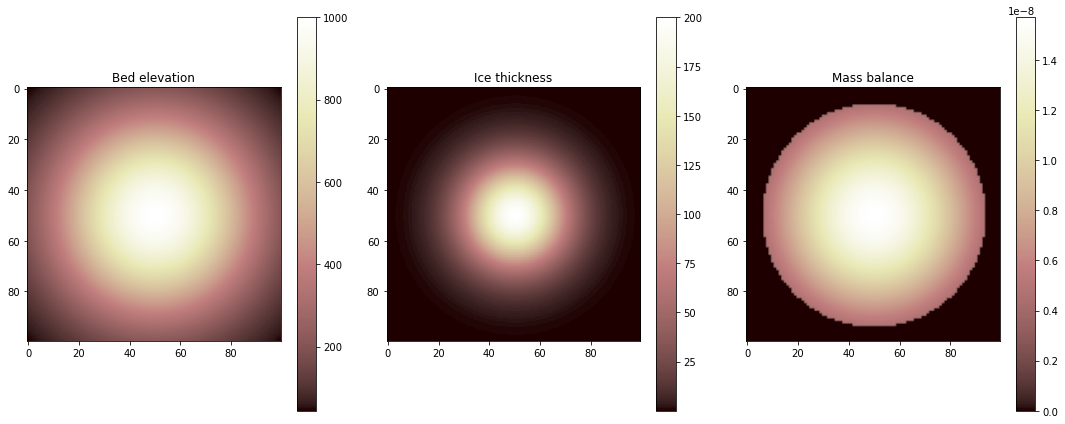

In [4]:
fig, ax = plt.subplots(1, 3, figsize = (15, 6))

im0 = ax[0].imshow(mg.at_node['bedrock_elevation'].reshape((100, 100)), cmap = 'pink')
fig.colorbar(im0, ax = ax[0])
ax[0].set_title('Bed elevation')

im1 = ax[1].imshow(mg.at_node['ice_thickness'].reshape((100, 100)), cmap = 'pink')
fig.colorbar(im1, ax = ax[1])
ax[1].set_title('Ice thickness')

im2 = ax[2].imshow(mg.at_node['mass_balance'].reshape((100, 100)), cmap = 'pink')
fig.colorbar(im2, ax = ax[2])
ax[2].set_title('Mass balance')

plt.tight_layout()
plt.show()

To help visualize the problem, below, this is a 3D plot of the initial surface elevation.

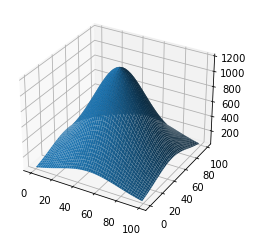

In [5]:
fig, ax = plt.subplots(subplot_kw = {"projection": "3d"})

nx = 100
ny = 100
x, y = np.meshgrid(range(nx), range(ny))
z = sia.grid.at_node['surface_elevation'].reshape((nx, ny))

ax.plot_surface(x, y, z)

plt.show()

Run 1000 time steps, at 1 second each. (We expect little to no change from this.)

/home/egp/anaconda3/envs/landlab/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
/home/egp/anaconda3/envs/landlab/lib/python3.9/site-packages/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


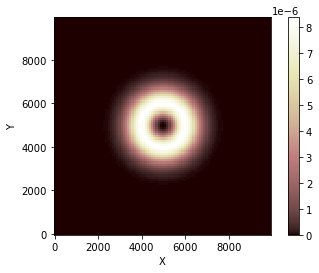

In [6]:
for i in range(1000):
    sia.run_one_step(1)
imshow_grid(mg, 'velocity')

First problem: this thing is moving at ~250 m/a, which is way too fast for a ~200m block of ice moving solely from deformation.

After simulating two weeks at 10-minute time steps, we note two problems: (1) the velocities are increasing to non-physical levels (and the maximum velocity increases monotonically, not shown here), and (2) an asymmetric signal appears in the lower left quadrant. Eventually, this signal devolves into multiple singular points and blows up the simulation.

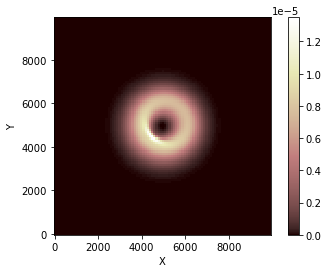

In [7]:
for i in range(6*24*14):
    sia.run_one_step(600)
imshow_grid(mg, 'velocity')

After another couple of days, the simulation gets close to blow-up.

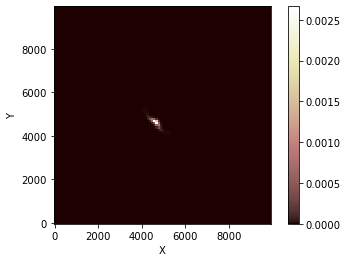

In [8]:
for i in range(6*24*6):
    sia.run_one_step(600)
imshow_grid(mg, 'velocity')